$\large Logica \  Computacional\ 14-Dezembro-2023 \ LCC$

$\textbf{Grupo 06:}$

* João Manuel Franqueira da Silva, A91638
* Eduardo Manuel Sousa Pereira, A70619

$\huge TP4 - Problema\ 1 $

No contexto do sistema de travagem ABS (“Anti-Lock Breaking System”), pretende-se construir um autómato híbrido que descreva o sistema e que  possa ser usado para verificar as suas propriedades dinâmicas.


- A componente discreta do autómato contém os modos:  `Start`,  `Free`,  `Stopping`, `Blocked`, e `Stopped`. 
    - o modo `Start` inicia o funcionamento com os valores iniciais das velocidades
    - no modo `Free`  não existe qualquer força de travagem; 
    - no modo `Stopping` aplica-se a força de travagem alta; 
    - no modo `Blocked` as rodas estão bloqueadas em relação ao corpo mas o veículo  move-se (i.e. derrapa) com pequeno atrito ao solo; 
    - no modo `Stopped` o veículo está imobilizado.

In [1]:
from pysmt.shortcuts import *
import pysmt.typing as types
import random as rn
from pysmt.typing import BOOL, REAL, INT, BVType, STRING
from IPython.display import Latex
import itertools

# Aútomato Híbrido

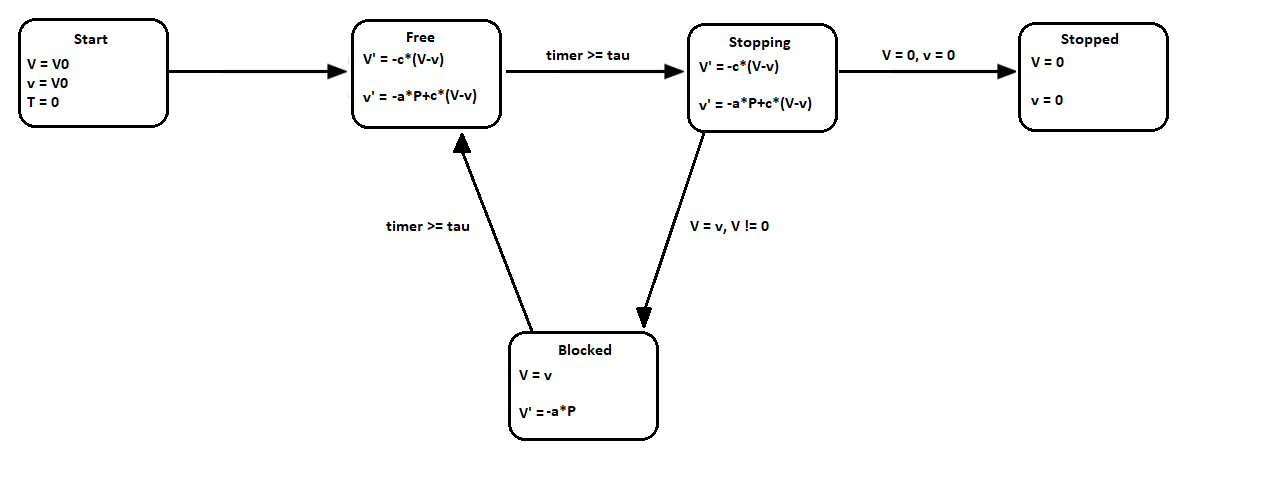

## Constantes
* $a\_blocked$ $\rightarrow$ atrito no modo em blocked.
* $a$ $\rightarrow$ atrito nos restantes modos.
* $c\_stopping$ $\rightarrow$ proporcionalidade de travagem em stopping.
* $c$ $\rightarrow$ proporcionalidade de travegem nos restantes modos.
* $P$ $\rightarrow$ peso do veículo.
* $tau$ $\rightarrow$ limite máximo do contador nos modos free e blocked.
* $dt$ $\rightarrow$ diferença da variavél tempo nas transições timed.
* $V0$ $\rightarrow$ velocidade inicial do veículo.
* $erro$ $\rightarrow$ para compensar possíveis erros pela falta de rigor da fórmulas do programa e evitar trajetórias de Zenão.

## Variáveis Continuas
* $V$ $\rightarrow$ velocidade do veículo m/s.
* $v$ $\rightarrow$ velocidade das rodas m/s.
* $timer$ $\rightarrow$ contador do sistema nos modos free e blocked.
* $T$ $\rightarrow$ tempo.

# Variáveis Discretas
* $M$ $\rightarrow$ modo de execução.

# Definição dos Switches

### Free $\rightarrow$ Stopping
$timer >= tau \quad \text{\(\lor\)} \quad (V <= erro \quad \text{\(\land\)} \quad v <= erro)$

### Stopping $\rightarrow$ Blocked
$V - v <= erro \quad \text{\(\land\)} \quad (V > erro \quad \text{\(\lor\)} \quad v > erro)$

### Stopping $\rightarrow$ Stopped
$V <= erro \quad \text{\(\land\)} \quad v <= erro$

### Blocked $\rightarrow$ Free
$timer >= tau \quad \text{\(\lor\)} \quad (V <= erro \quad \text{\(\land\)} \quad v <= erro)$

# Discretização das Relações


### Free $\rightarrow$ Free
$ V' - V = -c*(V-v)dt $

$ v' - v = (-a*P + c*(V-v))*dt $

### Stopping $\rightarrow$ Stopping
$ V' - V = -c\_stopping*(V-v)*dt $

$ v' - v = (-a*P + c\_stopping*(V-v))*dt $

### Blocked $\rightarrow$ Blocked
$ V = v $

$ V' - V = (-a\_blocked*P)*dt $

# Atribuição de valores

Valores inteiros para cada um dos Modos de execução.
 - Start $\rightarrow$ 0
 - Free $\rightarrow$ 1
 - Stopping $\rightarrow$ 2
 - Blocked $\rightarrow$ 3
 - Stopped $\rightarrow$ 4

In [2]:
erro = 0.2
tau = 0.1
a = 0.01
a_blocked = 0.009
c_stopping = 10
c = 0.5
P = 1000
dt = 0.1
V0 = 20

START = Int(0)
FREE = Int(1)
STOPPING = Int(2)
BLOCKED = Int(3)
STOPPED = Int(4)

# Definação do SFOTS 
Definiremos então, um SFOTS que modele a descretização do Autómato híbrido.

### Função declare

In [3]:
def declare(i):
    s = {}
    s['T'] = Symbol('T'+str(i), REAL)
    s['V'] = Symbol('V'+str(i), REAL)
    s['v'] = Symbol('v'+str(i), REAL)
    s['M'] = Symbol('M'+str(i), INT)
    s['timer'] = Symbol('timer'+str(i), REAL)
    return s

### Função init
Predicado $init$, que recebe um estado e verifica se este é um estado inicial válido.

In [4]:
def init(s,V0):
    a=Equals(s['T'],Real(0))
    b=Equals(s['V'],Real(V0))
    c=Equals(s['v'],Real(V0))
    d=Equals(s['M'],Int(0))
    e=Equals(s['timer'],Real(0))
    return And(a,b,c,d,e)

### Função transição
Função $trans$, que recebendo dois estados, $s$ estado atual, e $p$ estado para onde de pretende transisitar, verifica se esta é uma transição válida do programa.

In [5]:
def trans(s, p):
    
    #UNTIMED
    start_free= And(
        Equals(s['M'],START),
        Equals(p['M'],FREE),
        Equals(p['V'],s['V']),
        Equals(p['v'],s['v']),
        Equals(p['T'],s['T']),
        Equals(p['timer'], Real(0))
    )

    free_stopping= And(
        Equals(s['M'],FREE),
        Equals(p['M'],STOPPING),
        Equals(p['V'],s['V']),
        Equals(p['v'],s['v']),
        Equals(p['T'],s['T']),
        Equals(p['timer'],Real(0)),
        Or(s['timer']>=tau, And(s['V'] <= erro, s['v'] <= erro))
    )
    
    stopping_stopped= And(
        Equals(s['M'],STOPPING),
        Equals(p['M'],STOPPED),
        Equals(p['T'],s['T']),
        Equals(p['timer'],Real(0)),
        s['v'] <= erro,
        s['V'] <= erro,
        s['v'] >= -erro,
        s['V'] >= -erro,
        Equals(p['V'], Real(0)),
        Equals(p['v'], Real(0))
    )
    
    stopping_blocked = And(
        Equals(s['M'],STOPPING),
        Equals(p['M'],BLOCKED),
        Equals(p['V'], s['V']),
        Equals(p['v'], s['v']),
        Equals(p['T'], s['T']),
        Equals(p['timer'],Real(0)),
        s['V'] - s['v'] <= erro,
        Or(
            p['V'] > erro,
            p['v'] > erro
        )
    )
    
    blocked_free= And(
        Equals(s['M'],BLOCKED),
        Equals(p['M'],FREE),
        Equals(p['V'], s['V']),
        Equals(p['v'], s['v']),
        Equals(p['T'], s['T']),
        Equals(p['timer'], Real(0)),
        Or(s['timer']>=tau, s['V']<=erro, s['v']<=erro)
    )
    
    #TIMED
    free_free= And(
        Equals(s['M'],FREE),
        Equals(p['M'],FREE),
        Equals(p['V'] - s['V'], (-c*(s['V']-s['v']))*dt),
        Equals(p['v'], s['v'] + (-a*P + c*(s['V']-s['v']))*dt),
        Equals(p['timer'], s['timer']+dt),
        Equals(p['T'], s['T']+dt),
        p['timer'] <= tau,
        Or(p['V']>erro, p['v']>erro)
    )
    
    stopping_stopping= And(
        Equals(s['M'],STOPPING),
        Equals(p['M'],STOPPING),
        Equals(p['timer'], Real(0)),
        Equals(p['T'], s['T']+dt),
        Equals(p['V']-s['V'], (-c_stopping*(s['V']-s['v']))*dt),
        Equals(p['v']-s['v'], (-a*P + c_stopping * (s['V']-s['v']))*dt),
        s['V'] - s['v'] > erro,
        s['V'] >= s['V'],
        Or(s['V']>erro, s['v']>erro)
    )
    
    stopped_stopped=And(
        Equals(s['M'],STOPPED),
        Equals(p['M'],STOPPED),
        Equals(p['timer'], Real(0)),
        Equals(p['T'], s['T']+dt),
        Equals(p['V'], Real(0)),
        Equals(p['v'], Real(0))
        )
    
    blocked_blocked= And(
        Equals(s['M'],BLOCKED),
        Equals(p['M'],BLOCKED),
        Equals(p['T'],s['T']+dt),
        Equals(p['timer'],s['timer']+dt),
        s['V']-s['v'] <= erro,
        Equals(p['V'],s['V']+(-a_blocked*P)*dt),         
        p['V']-p['v'] <= erro, 
        p['V']-p['v'] >= -erro, 
        p['V']>0, 
        p['v']>0,
        p['timer'] <= tau,
        Or(s['V']>erro, s['v']>erro, s['v']<-erro, s['V']<-erro)
    )
    
    return Or(start_free,free_free, free_stopping, stopping_stopping,
             stopping_stopped, stopping_blocked, blocked_blocked,
             blocked_free, stopped_stopped)

### Função print_vars

In [6]:
def print_vars(s,solver):
    print("MODE: ",end="")
    x = solver.get_py_value(s['M'])
    if x == 0:
        print("START")
    elif x == 1:
        print("FREE")
    elif x == 2:
        print("STOPPING")
    elif x == 3:
        print("BLOCKED")
    elif x == 4:
        print("STOPPED")
    print("V: ", end="")
    print(float(solver.get_py_value(s['V'])))
    print("v: ", end="")
    print(float(solver.get_py_value(s['v'])))
    print("T: ", end="")
    print(float(solver.get_py_value(s['T'])))
    print("timer: ", end="")
    print(float(solver.get_py_value(s['timer'])))
    print("")
    print("")    

### Função gera_traco

In [7]:
def gera_traco(declare,init,trans,k,V_in):
    with Solver(name="z3") as solver:
        traco=[declare(i) for i in range(k)]
        solver.add_assertion(init(traco[0],V_in))

        for i in range(k-1):
            solver.add_assertion(trans(traco[i],traco[i+1]))

            
        if solver.solve():
            i=0
            print("is sat")
            for s in traco:
                print("ESTADO: ",end="")
                print(i)
                print_vars(s,solver)
                i=i+1
        else:
            print("unsat")

In [8]:
gera_traco(declare,init,trans,40,10)

is sat
ESTADO: 0
MODE: START
V: 10.0
v: 10.0
T: 0.0
timer: 0.0


ESTADO: 1
MODE: FREE
V: 10.0
v: 10.0
T: 0.0
timer: 0.0


ESTADO: 2
MODE: FREE
V: 10.0
v: 9.0
T: 0.1
timer: 0.1


ESTADO: 3
MODE: STOPPING
V: 10.0
v: 9.0
T: 0.1
timer: 0.0


ESTADO: 4
MODE: STOPPING
V: 9.0
v: 9.0
T: 0.2
timer: 0.0


ESTADO: 5
MODE: BLOCKED
V: 9.0
v: 9.0
T: 0.2
timer: 0.0


ESTADO: 6
MODE: BLOCKED
V: 8.1
v: 8.3
T: 0.30000000000000004
timer: 0.1


ESTADO: 7
MODE: FREE
V: 8.1
v: 8.3
T: 0.30000000000000004
timer: 0.0


ESTADO: 8
MODE: FREE
V: 8.11
v: 7.29
T: 0.4
timer: 0.1


ESTADO: 9
MODE: STOPPING
V: 8.11
v: 7.29
T: 0.4
timer: 0.0


ESTADO: 10
MODE: STOPPING
V: 7.29
v: 7.109999999999999
T: 0.5
timer: 0.0


ESTADO: 11
MODE: BLOCKED
V: 7.29
v: 7.109999999999999
T: 0.5
timer: 0.0


ESTADO: 12
MODE: BLOCKED
V: 6.39
v: 6.501111111111111
T: 0.6000000000000001
timer: 0.1


ESTADO: 13
MODE: FREE
V: 6.39
v: 6.501111111111111
T: 0.6000000000000001
timer: 0.0


ESTADO: 14
MODE: FREE
V: 6.395555555555555
v: 5.4955555555

# Prova de Propriedades

* Verifique nesse modelo
    1. Que as condições de segurança são invariantes do sistema
    2. Que o sistema atinge o estado `stopped` eventualmente.

A condição de segurança estabelece que o sistema não permaneça no modo free  ou no modo blocked mais do que $tau$ segundos.
Definimos então o predicado $timer$, que recebe um estado $s$, e verifica se:

$( s[M]==FREE \quad \text{\(\lor\)} \quad s[M]==BLOCKED ) \quad\text{\(\implies\)}\quad  s[timer] <= tau $

In [9]:
def timer(s):
    r=Implies(Or(Equals(s['M'],FREE),Equals(s['M'],BLOCKED)),s['timer']<=tau)
    return r

Desenvolvemos também então o predicado $stops$ que verifica que se o veiculo encontra-se no estado $STOPPED$

$s[M] == STOPPED $

In [10]:
def stops(s):
    r=Equals(s['M'],STOPPED)
    return r

Queremos verificar que o predicado timer é um invariante do sistema, para verificar esta propriedade, podemos utilizar o método da k_indução que consiste em:

- $\phi$ é válido nos estados iniciais, ou seja, $\mathit{init}(s) \rightarrow \phi(s)$

- Para qualquer estado, assumindo que $\phi$ é verdade, se executarmos uma transição, $\phi$ continua a ser verdade no próximo estado, ou seja, $\phi(s) \wedge \mathit{trans}(s,p) \rightarrow \phi(p)$.

Um processo parecido com este seria generalizar a indução assumindo no passo indutivo que o invariante é válido nos $k$ estados anteriores. 

In [11]:
def kinduction_always(declare,init,trans,inv,k,v_in):
    with Solver(name="z3") as solver:
        s = [declare(i) for i in range(k)]
        solver.add_assertion(init(s[0],v_in))
        for i in range(k-1):
            solver.add_assertion(trans(s[i],s[i+1]))
            
        for i in range(k):
            solver.push()
            solver.add_assertion(Not(inv(s[i])))
            if solver.solve():
                print(f"> Contradição! O invariante não se verifica nos k estados iniciais.")
                i=0
                for state in s:
                    print("ESTADO: ",end="")
                    print_vars(state,solver)
                    i=i+1
                return
            solver.pop()
        
        s2 = [declare(i+k) for i in range(k+1)]
        
        for i in range(k):
            solver.add_assertion(inv(s2[i]))
            solver.add_assertion(trans(s2[i],s2[i+1]))
        
        solver.add_assertion(init(s2[0],v_in))
        
        solver.add_assertion(Not(inv(s2[-1])))
        
        if solver.solve():
            print(f"> Contradição! O passo indutivo não se verifica.")
            return
        
        print(f"> A propriedade verifica-se por k-indução (k={k}).")

Para provar que o timer nao exceda um certo limite, usaremos támbem o bmc_always, que consiste encontrar um possivel traço onde o invariante a verificar seja inválido num certo estado, o procedimento é interrompido mal um contra_exemplo seja encontrado.

In [12]:
def bmc_always(declare,init,trans,inv,K,v_in):
    with Solver(name="z3") as solver:
        traco = [declare(i) for i in range(K)]
        solver.add_assertion(init(traco[0],v_in))
        
        for k in range(K):
            if k>0:
                solver.add_assertion(trans(traco[k-1], traco[k]))
            
            solver.push()
            solver.add_assertion(Not(inv(traco[k])))

            if solver.solve():
                print(f"> Invariante não se verifica nos primeiros {k+1} estados")                
            else:
                if k==K-1:
                    print(f"> Invariante verifica-se nos {K} estados")
                else:
                    solver.pop()

Para a prova de que eventualmente, o veículo chega a um estado de paragem, usaremos o algoritmo bmc_eventually dado nas aulas praticas, que, dada uma função que gera uma cópia das variáveis do estado, um predicado que testa se um estado é inicial, um predicado que testa se um par de estados é uma transição válida, uma propriedade cuja inevitabilidade se pretende verificar, e um número positivo K, procura um contra-exemplo para essa propriedade considerando apenas os primeiros K estados de execução do programa.

In [13]:
def bmc_eventually(declare,init,trans,prop,bound,v_in):
    with Solver(name="z3") as solver:
        states = [declare(i) for i in range(bound)]
        solver.add_assertion(init(states[0],v_in))
        
        for i in range(bound-1):
            solver.add_assertion(trans(states[i],states[i+1]))
            
        for i in range(bound):
            solver.push()
            solver.add_assertion(Not(prop(states[i])))
            
            if solver.solve():
                solver.pop()       
            else:
                print(f"> A propriedade occorre em {bound} estados")
                return
                
        print(f"> A propriedade nao ocorre em {bound} estados")
        return

In [14]:
kinduction_always(declare,init,trans,timer,30,10)

> A propriedade verifica-se por k-indução (k=30).


In [15]:
bmc_always(declare,init,trans,timer,30,10)

> Invariante verifica-se nos 30 estados


In [16]:
bmc_eventually(declare,init,trans,stops,50,10)

> A propriedade occorre em 50 estados
